# TL;DR

This notebook is used to run experiments for offline data analysis section in the Aquarius paper. 

# Import & Utils

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from math import pi
import time
import datetime

from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import json
import math
import random

%matplotlib inline
min_max_scaler = preprocessing.MinMaxScaler()

sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

In [4]:
'''
write data to json file
'''
def json_write2file(data, filename):
    with open(filename, "w") as write_file:
        json.dump(data, write_file, indent=4) # w/ indent the file looks better

'''
read data from json file
'''
def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)
    
# @desc:   read lines from a file into a list
# @params: (str)filename
# @return: list of strings
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }

In [5]:
COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]

MARKERS = ["o", "^", "*", "P"]

trace_types = [
    'PHP For-Loop', 
    'PHP File', 
    'Wiki',
    'Wiki (Flooded)'
]

color_map = {t: COLORS[i] for i,t in enumerate(trace_types)}
marker_map = {t: MARKERS[i] for i,t in enumerate(trace_types)}

In [6]:
shm_layout = json_read_file("../../src/lb/shm_layout_base_dev.json")

feature_as_cnt = [_[1] for _ in shm_layout["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
feature_as_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
feature_lb_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_lb"]] # features gathered for LB node w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = feature_as_cnt + ["_".join((a, b)) for a in feature_as_res for b in RES_FEATURE_ENG]
# avg AS features and append LB features
FEATURE_LB_ALL = FEATURE_AS_ALL + \
    ["_".join((a, b)) for a in feature_lb_res for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

# Table of Contents

1. Run experiments
2. Load datasets
3. Generate Plots

## Run Experiments

### Unit Test

In [91]:
import sys
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu

In [470]:
def prepare_scripts(autoscale_mode):
    if autoscale_mode == 'wavenet':
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/wavenet.model cisco@localhost:~/'
        tu.subprocess_cmd(cmd)
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/wavenet.py cisco@localhost:~/baseline.py'
        tu.subprocess_cmd(cmd)
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/preprocess_seq.joblib cisco@localhost:~/preprocess.joblib'
        tu.subprocess_cmd(cmd)
    elif autoscale_mode == 'linear':
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/lin_reg.joblib cisco@localhost:~/'
        tu.subprocess_cmd(cmd)
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/lin_reg.py cisco@localhost:~/baseline.py'
        tu.subprocess_cmd(cmd)
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/preprocess_non_seq.joblib cisco@localhost:~/preprocess.joblib'
        tu.subprocess_cmd(cmd)
    elif autoscale_mode == 'oracle':
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/oracle.py cisco@localhost:~/baseline.py'
        tu.subprocess_cmd(cmd)
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/preprocess_non_seq.joblib cisco@localhost:~/preprocess.joblib'
        tu.subprocess_cmd(cmd)
    elif autoscale_mode == 'active':
        cmd = 'scp -r -P 8900 ../../src/lb/autoscale/active.py cisco@localhost:~/baseline.py'
        tu.subprocess_cmd(cmd)

In [517]:
lb_method = 'ecmp'
mode = 'wavenet'
trace='wiki_600'
experiment='atc-prediction'
sample='hour23_step.csv'
from_orig=None
config_file_prefix='1lb-conf00-14'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=None
ep=1

In [518]:
server_id = 1
config_file = config_file_prefix+'-'+str(server_id)
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0]}
ip_remote = tu.COMMON_CONF['net']['physical_server_ip']

task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-ecmp-hour23_step-1lb-conf00-14


In [519]:
for server_id in [0]:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
#     print(cmd)
    tu.subprocess.Popen(cmd, shell=True)

In [520]:
tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

Create LB node image...


In [521]:
tu.runall()
time.sleep(10)

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost


In [522]:
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)

LB Node 0: pass


In [523]:
prepare_scripts(mode)

In [524]:
# start gathering at LB node
for lb in tu.NODES['lb']:
    lb.run_init_bg()

In [525]:
# run traffic
t0 = time.time()
cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
    experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])

tu.subprocess_cmd(cmd)
print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))

Trace replay over w/ total time: 301.988s


In [613]:
# fetch results from nodes
for server_id in [0]:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
    if server_id == 0:
        cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)
#     print(cmd)

In [527]:
for lb in tu.NODES['lb']:
    lb.fetch_result(task_dir, ep)

In [614]:
tu.shutall()

## Pipeline

In [656]:
def run_pipeline(
    lb_method = 'ecmp',
    mode='wavenet',
    trace='wiki_600',
    experiment='atc-prediction',
    sample='hour23_step.csv',
    from_orig=None,
    config_file_prefix='1lb-conf00-14',
    colocate=None,
    colocate_freq=0.0001,
    twist=False,
    clip_n=None,
    eps=[1]):

    server_id = 1
    config_file = config_file_prefix+'-'+str(server_id)
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0]}
    ip_remote = tu.COMMON_CONF['net']['physical_server_ip']

    for ep in eps:
        task_name, task_dir, nodes = tu.init_task_info(
            experiment=experiment,
            lb_method=lb_method,
            trace=trace+'-'+mode,
            sample=sample,
            filename=config_file+'.json',
            colocate=colocate,
            colocate_freq=colocate_freq,
            alias=config_file_prefix
        )

        print(">> run task {}".format(task_name))

        for server_id in [0]:
            if clip_n and server_id == 0:
                clip_str = '-n {}'.format(clip_n)
            else:
                clip_str = ''

            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace+'-'+mode, sample, config_file_remote[server_id], clip_str)
        #     print(cmd)
            tu.subprocess.Popen(cmd, shell=True)

        tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

        tu.runall()
        time.sleep(10)

        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)

        prepare_scripts(mode)

        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            experiment, colocate_freq, lb_method, trace+'-'+mode, sample, config_file_remote[0])

        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))

        # fetch results from nodes
        for server_id in [0]:
            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace+'-'+mode, sample, config_file_remote[server_id], ep)
            if server_id == 0:
                cmd += ' --shutdown'
            tu.subprocess.Popen(cmd, shell=True)
        #     print(cmd)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, ep)

        tu.shutall()

In [839]:
modes = ['wavenet', 'linear', 'active', 'oracle']
eps = range(30)
for mode in modes:
    run_pipeline(
        lb_method = 'ecmp',
        mode=mode,
        trace='wiki_600',
        experiment='atc-prediction',
        sample='hour23_step.csv',
        from_orig=None,
        config_file_prefix='1lb-conf00-14',
        colocate=None,
        colocate_freq=0.0001,
        twist=False,
        clip_n=None,
        eps=eps,
    )
    time.sleep(3)

init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.245s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task 

node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.273s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 rea

node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.354s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 read

node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.851s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready

In [839]:
# for usage
modes = ['wavenet', 'linear', 'active', 'oracle']
eps = range(30, 32)
for mode in modes:
    run_pipeline(
        lb_method = 'ecmp',
        mode=mode,
        trace='wiki_600',
        experiment='atc-prediction',
        sample='hour23_step.csv',
        from_orig=None,
        config_file_prefix='1lb-conf00-14',
        colocate=None,
        colocate_freq=0.0001,
        twist=False,
        clip_n=None,
        eps=eps,
    )
    time.sleep(3)

init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.245s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task 

node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.273s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 rea

node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.354s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 read

node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready: ssh -p 9007 cisco@localhost
node_server_8 ready: ssh -p 9008 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 302.851s
init_task_info: alias=1lb-conf00-14
alias=1lb-conf00-14
>> run task wiki_600-oracle-ecmp-hour23_step-1lb-conf00-14
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
node_server_7 ready

## Load Dataset

In [1]:
## Clip Outliers

from scipy import stats
import numpy as np

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## Compare metrics

- metric1: page load time (QoS)
- metric2: cost (Number of servers * time)
- metric4: number of servers within defined range
- metric3: number of operations (Operational complexity)

# Plot ground truth CPU usage

In [3]:
def load_shm(filename, as_range, ep, clip=True):
    global FEATURE_AS_ALL, GT, n_server
    lines = read_file(filename)
    lines = lines[1:-1]
    if clip:
        lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    df_dict = {
        'ts': [],
        'asid': [],
        '#cpu': [],
        'ep': [],
    }
    df_dict.update({k: [] for k in FEATURE_AS_ALL})
    df_dict.update({k: [] for k in GT})
    t0 = 0
    ncpu = 1
    for i, l in enumerate(lines):
        d = json.loads(l)
        if t0 == 0:
            t0 = d['ts']
            ts = 0
        else:
            ts = d['ts'] - t0
        for as_id in as_range:
            for i, k in enumerate(FEATURE_AS_ALL):
                df_dict[k].append(d['feature_as'][as_id][i])
            for i, k in enumerate(GT):
                if k != 'asid':
                    df_dict[k].append(d['gt'][as_id][i])
                else:
                    df_dict[k].append(n_server-as_id)
            df_dict['#cpu'].append(ncpu)
            df_dict['ts'].append(ts)
    for k, v in df_dict.items():
        if k in ['asid', '#cpu']: continue
    df_dict['cpu usage'] = df_dict['cpu']
    df_dict['#thread'] = df_dict['apache']
    df_dict['ep'] = ep
    del(df_dict['cpu'])
    del(df_dict['apache'])
    return pd.DataFrame.from_dict(df_dict)

In [10]:
modes = ['wavenet', 'linear', 'active', 'oracle']
method = 'ecmp'
dfs = []
data_dir = '../../data/results/atc-prediction'
n_server = 14
n_ep = 30
server_range = list(range(1, n_server+1))[::-1]
trace = 'hour23_step-1lb-conf00-{}'.format(n_server)

In [10]:
for mode in modes:
    traffic_type = 'wiki_600-{}'.format(mode)
    for ep in range(n_ep):
        filename = "{}/{}/{}/{}/{}_log_ep{}/shm.json".format(data_dir, traffic_type, method, trace, 0, ep)
        df = load_shm(filename, server_range, ep, clip=False)
        df['Mode'] = mode
        dfs.append(df)
df_modes = pd.concat(dfs)

In [34]:
def plot_parallel_eps(
    key_col='asid',
    x_col='ts',
    cols2plot = ['cpu usage'],
    xlim=(0, 300),
    smoothbox=3,
    ylim=(-0.05,1.05),
    xlabel = 'Time (s)',
    ylabel = 'CPU Usage (%)',
    keys = range(n_server),
    mode = 'wavenet',
    title = mode,
    logy = False,
    logx = False,
    save2filename = None,
):
    fig, axs = plt.subplots(len(keys), figsize=(6,10), dpi=96, sharex=True, sharey=True)
    df2plot = df_modes.loc[df_modes['Mode']==mode]
    for ep in range(n_ep):
        df2plot_ep = df2plot.loc[df2plot['ep']==ep]
#         print("=== episode {} ===".format(ep))
        for i, ax in zip(keys, axs):
            df2plot_ep_as = df2plot_ep.loc[df2plot_ep[key_col] == i]
            for col in cols2plot:
                if len(df2plot_ep_as) > 0:
                    v = df2plot_ep_as[col].values
                    x = df2plot_ep_as[x_col]
                else:
                    v = np.zeros(len(x))
#                 print("server {} average cpu: {:.3f}".format(i, np.mean(v)))
                if x_col:
                    ax.plot(x, smooth(v, smoothbox), label='ep{}'.format(ep), alpha=0.5)
                else:
                    ax.plot(smooth(v, smoothbox), label='ep{}'.format(ep), alpha=0.5)
            if ylim: ax.set_ylim(ylim)
#     plt.legend()
    if xlim: plt.xlim(xlim)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: 
        plt.suptitle(ylabel, x=0.05, y=0.57, rotation=90)
    # if title: plt.title(title)
    if logy: plt.yscale('log')
    if logx: plt.xscale('log')
    plt.xticks(range(0, 300, 60), range(0, 300, 60))
    plt.yticks([0., 0.5, 1.], range(0, 101, 50))
    if save2filename: fig.savefig(save2filename, bbox_inches='tight', transparent=True)
    plt.show()

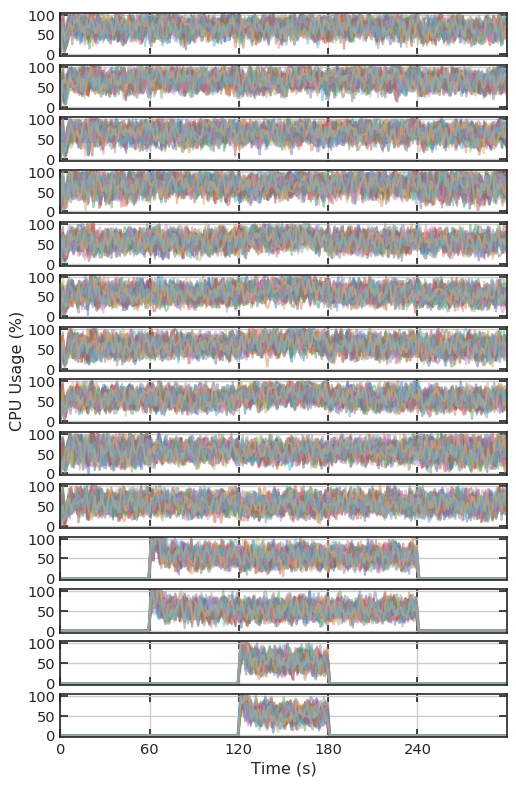

In [35]:
plot_parallel_eps(mode='oracle', save2filename='../../data/figures/atc/application/autoscale/cpu-oracle.pdf')

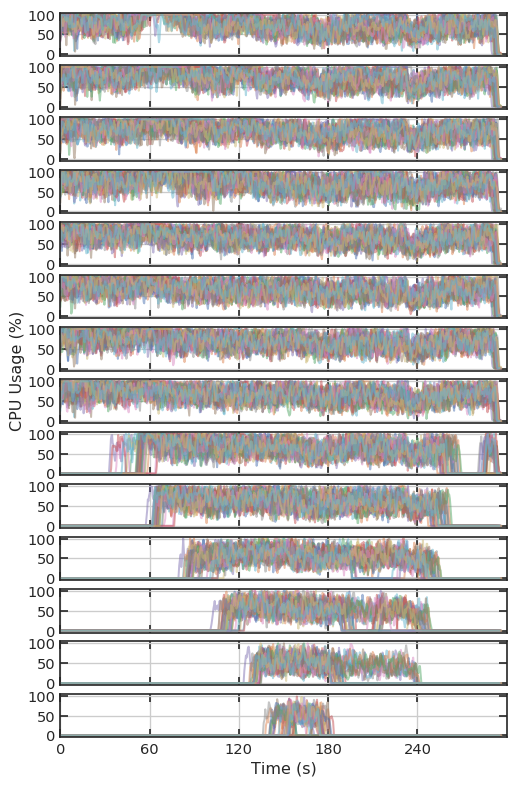

In [36]:
plot_parallel_eps(mode='wavenet', save2filename='../../data/figures/atc/application/autoscale/cpu-wavenet.pdf')

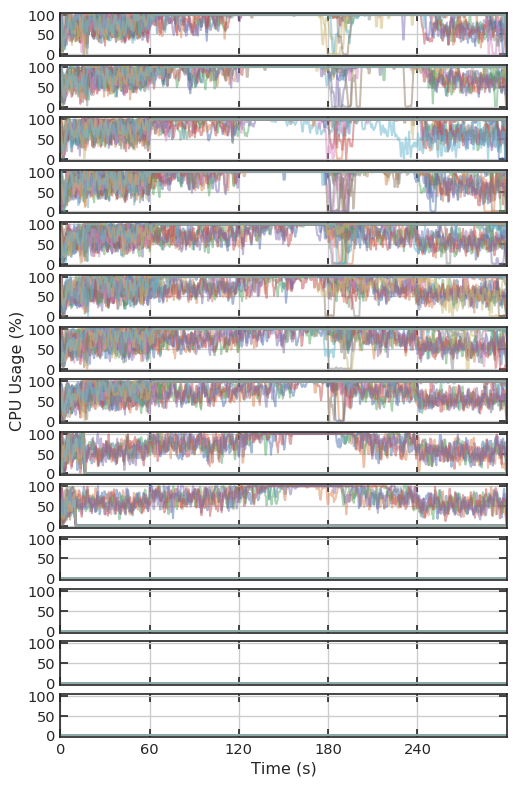

In [37]:
plot_parallel_eps(mode='linear', save2filename='../../data/figures/atc/application/autoscale/cpu-linear.pdf')

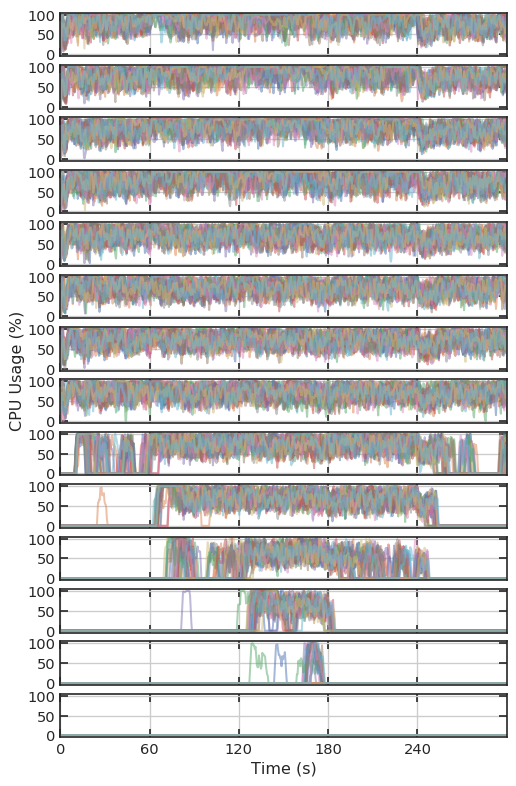

In [38]:
plot_parallel_eps(mode='active', save2filename='../../data/figures/atc/application/autoscale/cpu-active.pdf')

### Plot decisions

In [946]:
wiki_trace_test = pd.read_csv('../../data/trace/wiki_600/hour{}.csv'.format(23), sep='\t', header=None)
wiki_trace_test = wiki_trace_test.rename(columns={0: 'time', 1: 'url'})
wiki_trace_test.time -= wiki_trace_test.time[0]

In [947]:
segs = []
bar_lo = 0
for barrier, perc in zip([60, 120, 180, 240, 300], [0.7, 0.86, 1., .86, .7]): # hour23_step
    queries = wiki_trace_test.loc[(wiki_trace_test.time > bar_lo) & (wiki_trace_test.time < barrier)]
    rows = sorted(np.random.choice(queries.index.values, int(perc*len(queries)), replace=False))
    segs.append(queries.loc[rows])
    bar_lo = barrier

In [ ]:
wiki_rate = []

In [1000]:
xs_mode_ep = {}
n_servers_mode_ep = {}
cpus_mode_ep = {}

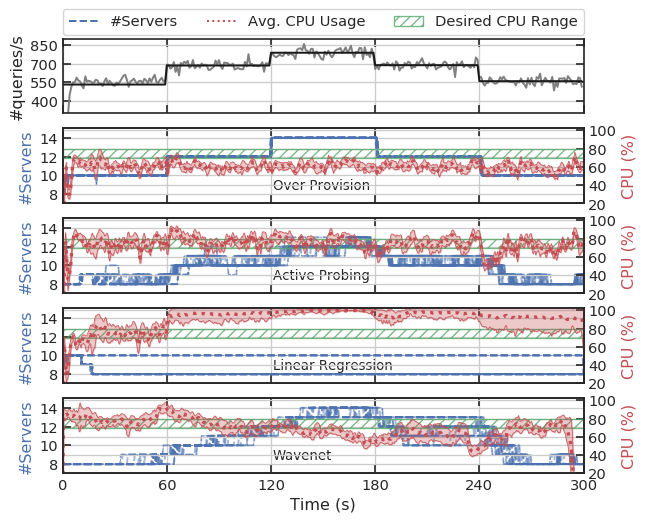

In [1070]:
smooth_box = 3
time_interval = 0.5
n_ep = 30
t_total = 300
n_server_max = 14
n_server_min = 8

f, axs = plt.subplots(5, 1, figsize=(7,6), dpi=96, sharex=True)

if len(wiki_rate) == 0:
    df = pd.concat(segs)
    t = df.iloc[0].time
    n = 0
    i = 0
    step = 1
    res = []
    while t < max(df.time):
        res.append(len(df.loc[(df.time > t) & (df.time < t+1)]))
        t += 1
    wiki_rate = res
axs[0].plot(wiki_rate, color='grey')
axs[0].plot(np.array([[np.mean(wiki_rate[i:i+60])]*60 for i in range(0, 300, 60)]).reshape(-1), color='k')
axs[0].set_ylabel('#queries/s')
axs[0].set_ylim(300, 900)
plt.sca(axs[0])
plt.yticks(range(400, 900, 150), range(400, 900, 150))
axs[0].plot(0, 0, '--', color='b', label='#Servers')
axs[0].plot(0, 0, ':', color='r', label='Avg. CPU Usage')
axs[0].fill_between([0],[0],[0], facecolor="none",alpha=0.8, edgecolor='g', hatch='///', label='Desired CPU Range')
axs[0].legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)


for i, mode in enumerate(modes[::-1]):
    axs[i+1].set_ylabel("#Servers", color='b')
    axs[i+1].text(121, 8.5, "%s" % (METHOD_MAPPER[mode]))
    color = COLORS_DICT[mode]
    ax_twin = axs[i+1].twinx()
    x = range(0, 301, 10)
    ax_twin.fill_between(x, [70]*len(x), [80]*len(x), hatch='///', facecolor="none", alpha=0.8, edgecolor='g')
    
    
    if set(xs_mode_ep.keys()) != set(modes):
        xs_mode_ep[mode] = []
        n_servers_mode_ep[mode] = []
        cpus_mode_ep[mode] = []

    for ep in range(n_ep):
        if len(xs_mode_ep[mode]) < n_ep:
        
            df = df_modes.loc[(df_modes['Mode'] == mode)&(df_modes['ep'] == ep)].copy()
            for asid in range(n_server_max):
                df.loc[df['asid']==asid, 'cpu usage'] = smooth(df.loc[df['asid']==asid, 'cpu usage'],3)
            t0 = 0
            n_server = [8]
            x = [0]
            cpu_all_avg = [0]
            while t0 < t_total:
            # while t0 < 100:
                df_step = df.loc[(df.ts > t0) & (df.ts < t0+time_interval)]
                cpu_avg = np.array([df_step.loc[df_step.asid == asid]['cpu usage'].mean()*100 for asid in df_step.asid.unique()])
                cpu_avg = [cpu for cpu in cpu_avg if cpu > 0]
                n_as = len(cpu_avg)
                t0 += time_interval
                if n_as > 0:
                    n_server.append(max(n_server_min, n_as)) 
                    cpu_all_avg.append(np.mean(cpu_avg))
                else: # miss data point
                    n_server.append(n_server[-1])
                    cpu = cpu_all_avg[-1]
                    cpu_all_avg.append(cpu)
                x.append(t0)

    #         plt.plot(x, cpu_all_avg, '--', color=color)
            xs_mode_ep[mode].append(x)
            n_servers_mode_ep[mode].append(n_server)
            cpus_mode_ep[mode].append(cpu_all_avg)
#         ax_twin.plot(xs_mode_ep[mode][ep], cpus_mode_ep[mode][ep], ':', color='r', alpha=0.15)
        axs[i+1].plot(xs_mode_ep[mode][ep], n_servers_mode_ep[mode][ep], '--', color='b', alpha=0.5)

    cpu_mean = np.array(cpus_mode_ep[mode]).mean(axis=0)
    cpu_std = np.array(cpus_mode_ep[mode]).std(axis=0)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean, ':', color='r', linewidth=2.5)
    ax_twin.fill_between(xs_mode_ep[mode][ep], cpu_mean-cpu_std, cpu_mean+cpu_std, color='r', alpha=0.3)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean+cpu_std, '-', color='r', linewidth=0.5)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean-cpu_std, '-', color='r', linewidth=0.5)
#     ax_twin.plot(xs_mode_ep[mode][ep], np.array(cpus_mode_ep[mode]).min(axis=0), ':', color='r', linewidth=1.5)
#     n_server_mean = np.array(n_servers_mode_ep[mode]).mean(axis=0)
#     n_server_std = np.array(n_servers_mode_ep[mode]).std(axis=0)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean, '--', color='b', linewidth=2.5)
#     axs[i+1].fill_between(xs_mode_ep[mode][ep], n_server_mean-n_server_std, n_server_mean+n_server_std, color='b', alpha=0.3)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean+n_server_std, '-', color='b', linewidth=0.5)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean-n_server_std, '-', color='b', linewidth=0.5)

    axs[i+1].plot(xs_mode_ep[mode][ep], np.array(n_servers_mode_ep[mode]).max(axis=0), '--', color='b', linewidth=0.5)
    axs[i+1].plot(xs_mode_ep[mode][ep], np.array(n_servers_mode_ep[mode]).min(axis=0), '--', color='b', linewidth=0.5)
    axs[i+1].set_ylim([7, 15])
    plt.sca(axs[i+1])
#     plt.yticks([7, 9, 11, 13, 15], [7, 9, 11, 13, 15])
    plt.yticks(range(8, 15, 2), range(8, 15, 2))
    ax_twin.set_ylabel("CPU (%)", color='r')
    ax_twin.set_ylim([20, 102])
    plt.sca(ax_twin)
    plt.yticks(range(20, 102, 20), range(20, 102, 20))
    

    
#     axs[0].plot(0,0, '-', color=color, label=METHOD_MAPPER[mode])
# plt.plot(0,0,'--',color='k', label='Average CPU')
# axs[0].plot(0,0,':',color='k', label='Number of Servers')
axs[0].set_xlim(0,300)
axs[0].set_xticks(range(0, 301, 60))
axs[-1].set_xlabel('Time (s)')
# plt.sca(axs[0])
# plt.legend()
plt.show()

In [1063]:
f.savefig('../../data/figures/atc/application/autoscale/timeline.pdf', bbox_inches='tight', transparent=True)

## Check prediction accuracy

In [ ]:
for i, mode in enumerate(['active', '']):
    axs[i+1].set_ylabel("#Servers", color='b')
    axs[i+1].text(121, 8.5, "%s" % (METHOD_MAPPER[mode]))
    color = COLORS_DICT[mode]
    ax_twin = axs[i+1].twinx()
    x = range(0, 301, 10)
    ax_twin.fill_between(x, [70]*len(x), [80]*len(x), hatch='///', facecolor="none", alpha=0.8, edgecolor='g')
    
    
    if set(xs_mode_ep.keys()) != set(modes):
        xs_mode_ep[mode] = []
        n_servers_mode_ep[mode] = []
        cpus_mode_ep[mode] = []

    for ep in range(n_ep):
        if len(xs_mode_ep[mode]) < n_ep:
        
            df = df_modes.loc[(df_modes['Mode'] == mode)&(df_modes['ep'] == ep)].copy()
            for asid in range(n_server_max):
                df.loc[df['asid']==asid, 'cpu usage'] = smooth(df.loc[df['asid']==asid, 'cpu usage'],3)
            t0 = 0
            n_server = [8]
            x = [0]
            cpu_all_avg = [0]
            while t0 < t_total:
            # while t0 < 100:
                df_step = df.loc[(df.ts > t0) & (df.ts < t0+time_interval)]
                cpu_avg = np.array([df_step.loc[df_step.asid == asid]['cpu usage'].mean()*100 for asid in df_step.asid.unique()])
                cpu_avg = [cpu for cpu in cpu_avg if cpu > 0]
                n_as = len(cpu_avg)
                t0 += time_interval
                if n_as > 0:
                    n_server.append(max(n_server_min, n_as)) 
                    cpu_all_avg.append(np.mean(cpu_avg))
                else: # miss data point
                    n_server.append(n_server[-1])
                    cpu = cpu_all_avg[-1]
                    cpu_all_avg.append(cpu)
                x.append(t0)

    #         plt.plot(x, cpu_all_avg, '--', color=color)
            xs_mode_ep[mode].append(x)
            n_servers_mode_ep[mode].append(n_server)
            cpus_mode_ep[mode].append(cpu_all_avg)
#         ax_twin.plot(xs_mode_ep[mode][ep], cpus_mode_ep[mode][ep], ':', color='r', alpha=0.15)
        axs[i+1].plot(xs_mode_ep[mode][ep], n_servers_mode_ep[mode][ep], '--', color='b', alpha=0.5)

    cpu_mean = np.array(cpus_mode_ep[mode]).mean(axis=0)
    cpu_std = np.array(cpus_mode_ep[mode]).std(axis=0)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean, ':', color='r', linewidth=2.5)
    ax_twin.fill_between(xs_mode_ep[mode][ep], cpu_mean-cpu_std, cpu_mean+cpu_std, color='r', alpha=0.3)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean+cpu_std, '-', color='r', linewidth=0.5)
    ax_twin.plot(xs_mode_ep[mode][ep], cpu_mean-cpu_std, '-', color='r', linewidth=0.5)
#     ax_twin.plot(xs_mode_ep[mode][ep], np.array(cpus_mode_ep[mode]).min(axis=0), ':', color='r', linewidth=1.5)
#     n_server_mean = np.array(n_servers_mode_ep[mode]).mean(axis=0)
#     n_server_std = np.array(n_servers_mode_ep[mode]).std(axis=0)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean, '--', color='b', linewidth=2.5)
#     axs[i+1].fill_between(xs_mode_ep[mode][ep], n_server_mean-n_server_std, n_server_mean+n_server_std, color='b', alpha=0.3)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean+n_server_std, '-', color='b', linewidth=0.5)
#     axs[i+1].plot(xs_mode_ep[mode][ep], n_server_mean-n_server_std, '-', color='b', linewidth=0.5)

    axs[i+1].plot(xs_mode_ep[mode][ep], np.array(n_servers_mode_ep[mode]).max(axis=0), '--', color='b', linewidth=0.5)
    axs[i+1].plot(xs_mode_ep[mode][ep], np.array(n_servers_mode_ep[mode]).min(axis=0), '--', color='b', linewidth=0.5)
    axs[i+1].set_ylim([7, 15])
    plt.sca(axs[i+1])
#     plt.yticks([7, 9, 11, 13, 15], [7, 9, 11, 13, 15])
    plt.yticks(range(8, 15, 2), range(8, 15, 2))
    ax_twin.set_ylabel("CPU (%)", color='r')
    ax_twin.set_ylim([20, 102])
    plt.sca(ax_twin)
    plt.yticks(range(20, 102, 20), range(20, 102, 20))
    

In [6]:
!head ../../data/results/atc-prediction/wiki_600-wavenet/ecmp/hour23_step-1lb-conf00-14/0_log_ep0/lb.log

### Init. Logger rl-logger ###
[11.843s] delta = 8
cpu_mean =   0.608 |  0.506 |  0.611 |  0.628 |  0.541 |  0.543 |  0.502 |  0.649
actual_cpu =   0.333 |  1.000 |  1.000 |  1.000 |  1.000 |  0.421 |  0.944 |  0.333
autoscale: downscale (stay as 10)
[18.981s] delta = 5
cpu_mean =   0.711 |  0.689 |  0.691 |  0.651 |  0.707 |  0.687 |  0.660 |  0.719
actual_cpu =   0.950 |  1.000 |  1.000 |  0.500 |  1.000 |  1.000 |  0.810 |  1.000
autoscale: downscale (stay as 10)
[25.092s] delta = 3


In [12]:
lines = read_file('../../data/results/atc-prediction/wiki_600-wavenet/ecmp/hour23_step-1lb-conf00-14/0_log_ep0/lb.log')

In [13]:
len(lines)-1

973

In [17]:
cpu_means = [[float(cpu.strip()) for cpu in l.split('=')[-1].split('|')] for l in lines if 'cpu_mean =' in l]
actual_cpu = [[float(cpu.strip()) for cpu in l.split('=')[-1].split('|')] for l in lines if 'actual_cpu =' in l]

In [ ]:
for i in range(len(cpu_means)):
    

In [19]:
len(actual_cpu)

317

## Check QoS

In [7]:
def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
#     if ep == -1:
#         traces = [t for t in traces if 'ep' not in t]
#     else:
#         traces = [t for t in traces if 'ep{}'.format(ep) in t]
    traces = [t for t in traces if 'ep31' not in t and 'ep32' not in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
#             for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
            for k, plt_ in zip(['all'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }

In [11]:
modes = ['wavenet', 'linear', 'active', 'oracle']
method = 'ecmp'
plt_modes = {}
data_dir = '../../data/results/atc-prediction'
n_ep = 30
trace = 'hour23_step-1lb-conf00-{}'.format(n_server)

In [12]:
for mode in modes:
    print('=== mode {} ==='.format(mode))
    traffic_type = 'wiki_600-{}'.format(mode)
    filename = "{}/{}/{}/{}/".format(data_dir, traffic_type, method, trace)
    plt_ = get_page_load_time(filename, verbose=True)
    plt_modes[mode] = plt_

=== mode wavenet ===
=== mode linear ===
=== mode active ===
=== mode oracle ===


In [1]:
COLORS_DICT = {
    'hlb': "#3978af", 
    'wavenet': "#17b6c8", 
    'active': '#559d3f',
    'oracle': "#aecde1",
    'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'wcmp': "#ef8532", 
    'linear': "#d1342b", 
}

MARKER_DICT = {
    'lsq2':       "+",
    'linear':       ".",
    'oracle':       "o",
    'active':    "^",
    'wavenet':    "x",
    'active-wcmp': "3",
    'wcmp':   ">",
    'sed':   "v",
}


METHOD_MAPPER = {
    'hlb': "HLB", 
    'wavenet': "Wavenet", 
    'linear': 'Linear Regression',
    'oracle': "Over Provision",
    'active': "Active Probing",
    'active-wcmp': "Active WCMP",
    'wcmp': "WCMP", 
    'ecmp': "Round Robin", 
}

In [ ]:
fig = plt.figure(figsize=(6, 2), dpi=96)
for mode in modes:
    v = plt_modes[mode]['page_load_time']
    color = COLORS_DICT[mode]
    marker = MARKER_DICT[mode]
    print("=== {} ===".format(mode))
    percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
    print('[50th, 90th]-percentile: {}, {}'.format(percentiles[5], percentiles[-2]))
    print('average: {}'.format(np.mean(v)))

    plt.semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
    plt.plot([0.], [0.], marker=marker, color=color, label=METHOD_MAPPER[mode])

plt.xlim([1e-3, 1])
plt.ylim([0, 1])
plt.xlabel('Page Load Time (s)')
plt.ylabel('CDF')
plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [828]:
fig.savefig('../../data/figures/atc/application/autoscale/qos.pdf', bbox_inches='tight', transparent=True)

## Compare cost

In [23]:
def calculate_cost(filename, as_range, ep, clip=True):
    global FEATURE_AS_ALL, GT, n_server
    lines = read_file(filename)
    lines = lines[1:-1]
    if clip:
        lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    cost = [0.]*len(as_range)
#     t_last = [-1.]*len(as_range)
    t0 = 0
    cpus = []
    for i, l in enumerate(lines):
        d = json.loads(l)
        if t0 == 0:
            t0 = d['ts']
            ts = 0
            # initialize t_last
            t_last = [0.]*len(as_range)
        else:
            ts = d['ts'] - t0
        for j, as_id in enumerate(as_range):
            server_id = n_server - as_id
            cpu = d['gt'][as_id][0]
            if cpu > 0:
                cpus.append(cpu)
                if t_last[j] == -1: # the server just got up
                    t_last[j] = ts
            else:
                if t_last[j] >= 0: # the server just went down
                    assert(ts - t_last[j] >= 0)
                    cost[j] += ts - t_last[j]
                    t_last[j] = -1
    return cost, cpus

In [21]:
modes = ['wavenet', 'linear', 'active', 'oracle']
method = 'ecmp'
costs = {}
cpus = {}
data_dir = '../../data/results/atc-prediction'
n_server = 14
n_ep = 30
server_range = list(range(1, n_server+1))[::-1]
trace = 'hour23_step-1lb-conf00-{}'.format(n_server)

In [24]:
for mode in modes:
    traffic_type = 'wiki_600-{}'.format(mode)
    print("for mode {}".format(mode))
    costs[mode] = []
    cpus[mode] = []
    for ep in range(n_ep):
#         if ep in [16, 20, 23, 28, 29]: continue
        filename = "{}/{}/{}/{}/{}_log_ep{}/shm.json".format(data_dir, traffic_type, method, trace, 0, ep)
        cost, cpu_list = calculate_cost(filename, server_range, ep, clip=False)
        costs[mode].append(cost)
        cpus[mode].append(cpu_list)
        print("cost is {}".format(sum(cost)))
    cpus[mode] = [item for sublist in cpus[mode] for item in sublist]

for mode wavenet
cost is 3022.10067987442
cost is 3073.4819209575653
cost is 3074.3809525966644
cost is 3056.4382615089417
cost is 3173.5540268421173
cost is 3086.668855190277
cost is 2980.4393966197968
cost is 3150.2545471191406
cost is 3016.6932141780853
cost is 3167.298131465912
cost is 3149.3508977890015
cost is 2993.0130496025085
cost is 3049.1116037368774
cost is 3043.658472299576
cost is 3084.5852603912354
cost is 3124.6269941329956
cost is 3128.3629851341248
cost is 2952.0999822616577
cost is 3057.1220366954803
cost is 3138.926235437393
cost is 3092.1330955028534
cost is 3190.3073205947876
cost is 3176.8906803131104
cost is 3028.767017841339
cost is 3003.462987422943
cost is 3134.6838381290436
cost is 3047.5957770347595
cost is 3102.21191239357
cost is 3057.9110362529755
cost is 3001.1840109825134
for mode linear
cost is 2981.3149840831757
cost is 2977.189090490341
cost is 2982.816355228424
cost is 2979.8780088424683
cost is 2975.8726217746735
cost is 2533.818529844284
cost is 

In [25]:
for mode in modes:
    print("{}: {}".format(mode, np.mean(costs[mode])))

wavenet: 219.89836947690873
linear: 186.5129143215361
active: 211.44300799596877
oracle: 245.9716338509605


In [722]:
cpu_dict = {
    'cpu': cpus['wavenet']+cpus['linear']+cpus['active']+cpus['oracle'],
    'mode': ['wavenet']*len(cpus['wavenet'])+['linear']*len(cpus['linear'])+['active']*len(cpus['active'])+['oracle']*len(cpus['oracle']),
}
cpu_df = pd.DataFrame.from_dict(cpu_dict)

## Check number of actions

In [936]:
n_actions = {}

In [937]:
for mode in modes:
    traffic_type = 'wiki_600-{}'.format(mode)
    print("=== mode {} ===".format(mode))
    n_actions[mode] = []
    for ep in range(n_ep):
#         if ep in [16, 20, 23, 28, 29]: continue
        filename = "{}/{}/{}/{}/{}_log_ep{}/lb.log".format(data_dir, traffic_type, method, trace, 0, ep)
        lines = read_file(filename)
        actions = [l for l in lines if 'autoscale' in l and 'stay as' not in l]
        n_actions[mode].append(len(actions))
        print("#action is {}".format(n_actions[mode][-1]))
    print("-- average #action = {:.3f} --".format(np.mean(n_actions[mode])))
n_actions['oracle'] = [8]

=== mode wavenet ===
#action is 16
#action is 18
#action is 16
#action is 16
#action is 12
#action is 17
#action is 14
#action is 12
#action is 16
#action is 14
#action is 14
#action is 18
#action is 14
#action is 16
#action is 16
#action is 12
#action is 14
#action is 14
#action is 16
#action is 14
#action is 16
#action is 14
#action is 14
#action is 18
#action is 16
#action is 12
#action is 16
#action is 18
#action is 14
#action is 16
-- average #action = 15.100 --
=== mode linear ===
#action is 0
#action is 0
#action is 0
#action is 0
#action is 0
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
#action is 2
-- average #action = 1.667 --
=== mode active ===
#action is 28
#action is 30
#action is 20
#action is 30
#action is 2

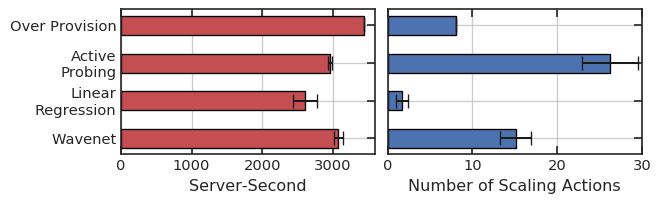

In [1060]:
f, axs = plt.subplots(1, 2, figsize=(7, 2), dpi=96, sharey=True)
# width of the bars
barWidth = 0.5
ks = ['Wavenet', 'Linear\nRegression', 'Active\nProbing', 'Over Provision']

# Choose the height of the blue bars
bars1 = [np.mean([sum(cost) for cost in cost_mode]) for mode, cost_mode in costs.items()]
# Choose the height of the error bars (bars1)
yer1 = [np.std([sum(cost) for cost in cost_mode]) for mode, cost_mode in costs.items()]
 # The x position of bars
r1 = np.arange(len(bars1))
# Create blue bars
axs[0].barh(ks, bars1, 
            height = barWidth, color='r', edgecolor = 'black', xerr=yer1, capsize=5)
  
# general layout
plt.sca(axs[0])
# plt.yticks(range(len(bars1)), , rotation=45)
# axs[0].set_xticks(range(len(bars1)), ['Wavenet', 'Linear\nRegression', 'Active\nProbing', 'Over Provision\n(Oracle)'])
axs[0].set_xlabel('Server-Second')
axs[0].set_xlim(0, 3600)


# Choose the height of the blue bars
bars1 = [np.mean(n_action) for n_action in n_actions.values()]
# Choose the height of the error bars (bars1)
yer1 = [np.std(n_action) for n_action in n_actions.values()] 
# The x position of bars
r1 = np.arange(len(bars1))
# Create blue bars
axs[1].barh(ks, bars1, height = barWidth, color='b', edgecolor='black', xerr=yer1, capsize=5)

    
# general layout
# axs[1].set_yticks(())
axs[1].set_xlabel('Number of Scaling Actions')
axs[1].set_xlim(0, 30)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Show graphic
plt.show()
f.savefig('../../data/figures/atc/application/autoscale/cost.pdf', bbox_inches='tight', transparent=True)

## Overhead

In [60]:
def get_cpu_mem_overhead(filename, ts_range=300, warmup=0.2, cooldown=0.8, memsize=4.039104, verbose=True):
    df = pd.DataFrame.from_csv(filename).reset_index()
    df = df.loc[df.ts < ts_range].reset_index()
    df = df.iloc[int(len(df)*warmup):int(len(df)*cooldown)]
    cpu_list = df.cpu_usage.values
    mem_list = df.used_ram.values*memsize/100
    if verbose:
        print("average cpu {:.3f}% mem {:.3f}GiB".format(cpu_list.mean(), mem_list.mean()))
    return cpu_list, mem_list

In [61]:
modes = ['wavenet', 'linear', 'active', 'oracle']
method = 'ecmp'
overhead = {}
data_dir = '../../data/results/atc-prediction'
n_server = 14
n_ep = 30
server_range = list(range(1, n_server+1))[::-1]
trace = 'hour23_step-1lb-conf00-{}'.format(n_server)

In [62]:
for mode in modes:
    traffic_type = 'wiki_600-{}'.format(mode)
    print("=== mode {} ===".format(mode))
    overhead[mode] = {
            'cpu': [],
            'mem': [],
        }
    for ep in range(n_ep):
        if ep in [16, 20, 23, 29, 28]: continue
        filename = "{}/{}/{}/{}/{}_log_ep{}/usage.log".format(data_dir, traffic_type, method, trace, 0, ep)
        cpu_list, mem_list = get_cpu_mem_overhead(filename)
        overhead[mode]['cpu'].append(cpu_list)
        overhead[mode]['mem'].append(mem_list)
        print("cost is {}".format(sum(cost)))
    overhead[mode]['cpu'] = [item for sublist in overhead[mode]['cpu'] for item in sublist]
    overhead[mode]['mem'] = [item for sublist in overhead[mode]['mem'] for item in sublist]

=== mode wavenet ===
average cpu 47.427% mem 3.140GiB
cost is 3451.739675760269
average cpu 47.442% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.716% mem 3.141GiB
cost is 3451.739675760269
average cpu 47.425% mem 3.138GiB
cost is 3451.739675760269
average cpu 47.894% mem 3.140GiB
cost is 3451.739675760269
average cpu 47.415% mem 3.140GiB
cost is 3451.739675760269
average cpu 47.331% mem 3.140GiB
cost is 3451.739675760269
average cpu 47.638% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.422% mem 3.140GiB
cost is 3451.739675760269
average cpu 48.028% mem 3.141GiB
cost is 3451.739675760269
average cpu 47.907% mem 3.138GiB
cost is 3451.739675760269
average cpu 47.475% mem 3.137GiB
cost is 3451.739675760269
average cpu 47.478% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.571% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.520% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.932% mem 3.139GiB
cost is 3451.739675760269
average cpu 47.433% mem 3.141GiB
co

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


average cpu 45.933% mem 2.839GiB
cost is 3451.739675760269
average cpu 46.325% mem 2.840GiB
cost is 3451.739675760269
average cpu 45.621% mem 2.839GiB
cost is 3451.739675760269
average cpu 45.522% mem 2.839GiB
cost is 3451.739675760269
average cpu 44.249% mem 2.841GiB
cost is 3451.739675760269
average cpu 43.579% mem 2.842GiB
cost is 3451.739675760269
average cpu 44.289% mem 2.841GiB
cost is 3451.739675760269
average cpu 45.466% mem 2.842GiB
cost is 3451.739675760269
average cpu 43.862% mem 2.840GiB
cost is 3451.739675760269
average cpu 43.907% mem 2.842GiB
cost is 3451.739675760269
average cpu 43.512% mem 2.841GiB
cost is 3451.739675760269
average cpu 43.583% mem 2.841GiB
cost is 3451.739675760269
average cpu 43.830% mem 2.840GiB
cost is 3451.739675760269
average cpu 43.568% mem 2.841GiB
cost is 3451.739675760269
average cpu 43.826% mem 2.841GiB
cost is 3451.739675760269
average cpu 43.511% mem 2.842GiB
cost is 3451.739675760269
average cpu 43.564% mem 2.841GiB
cost is 3451.7396757602

In [63]:
modes = ['wavenet', 'linear', 'active', 'oracle']
method = 'ecmp'
delays = {}
data_dir = '../../data/results/atc-prediction'
n_server = 14
eps = [31, 32]
server_range = list(range(1, n_server+1))[::-1]
trace = 'hour23_step-1lb-conf00-{}'.format(n_server)

In [64]:
for mode in modes:
    traffic_type = 'wiki_600-{}'.format(mode)
    print("=== mode {} ===".format(mode))
    delays[mode] = []
    for ep in eps:
        filename = "{}/{}/{}/{}/{}_log_ep{}/lb.log".format(data_dir, traffic_type, method, trace, 0, ep)
        lines = [l for l in read_file(filename) if 'autoscale-time' in l]
        delay = [float(l.split('time: ')[-1].strip('s'))*1000 for l in lines]
        delays[mode].append(delay)
        print("delay is {}".format(np.mean(delay)))
    delays[mode] = [item for sublist in delays[mode] for item in sublist]

=== mode wavenet ===
delay is 88.490625
delay is 88.86585365853658
=== mode linear ===
delay is 15.55
delay is 12.891891891891891
=== mode active ===
delay is 2.4773413897280965
delay is 2.3179190751445087
=== mode oracle ===
delay is 198.12269938650306
delay is 198.14489795918368


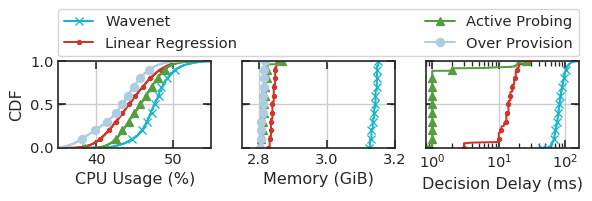

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(7, 1.2), dpi=96, sharex=False, sharey=True)
# for i, (setup, xlim, title) in enumerate(zip(configs, [[5e-2, 2]]*3, ['#LB={}'.format(i) for i in [1, 2, 3]])):
for i, (metric, xlim) in enumerate(zip(['cpu', 'mem'], [[35, 55], [2.75, 3.2]])):

    for mode in modes:
        v = overhead[mode][metric]
        color = COLORS_DICT[mode]
        marker = MARKER_DICT[mode]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
        axs[i].plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], marker=marker, color=color, label=METHOD_MAPPER[mode])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    if i == 0:
        plt.sca(axs[i])
        axs[i].legend(bbox_to_anchor=(0., 1.05, 3.4, .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
        axs[i].set_ylabel('CDF')
        axs[i].set_xlabel("CPU Usage (%)")
    else:
        axs[i].set_yticks([0.5], [''])
        axs[i].set_xlabel("Memory (GiB)")

    
    axs[i].set_xlim(xlim)
    axs[i].grid(True)

i=2
for mode in modes:
    if mode in ['oracle']: continue
    v = delays[mode]
    color = COLORS_DICT[mode]
    marker = MARKER_DICT[mode]
    percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
    axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
    axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
    axs[i].plot([0.], [0.], marker=marker, color=color, label=METHOD_MAPPER[mode])

axs[i].set_xlim(0.8,160)
axs[i].set_ylim([0,1.])
# axs[i].set_yscale('log')
axs[i].grid(True)
axs[i].set_yticks([0.5], [''])
# axs[i].set_xticks([1, 10, 100], [1, 10, 100])
axs[i].set_xlabel("Decision Delay (ms)")

fig.savefig('../../data/figures/atc/application/autoscale/overhead.pdf', bbox_inches='tight', transparent=True)

In [69]:
for fn_name, fn in zip(['avg.', '90th'], [np.mean, lambda x : np.percentile(x, 90)]):
    for metric in ['cpu', 'mem']:
        diff = fn(overhead['wavenet'][metric])-fn(overhead['active'][metric])
        print('{} {}: {:.5f} ({:.3%})'.format(fn_name,
                                            metric,
                                            diff,
                                            diff/fn(overhead['active'][metric])))


avg. cpu: 1.84416 (4.029%)
avg. mem: 0.32161 (11.413%)
90th cpu: 1.30000 (2.653%)
90th mem: 0.32313 (11.445%)
